In [1]:
# Author: Rakesh K. Yadav

%cd /content
# remove older folder if present
!rm -rf PyTorch-RNN-Tutorial
# clone the latest version
!git clone https://github.com/rakesh-yadav/PyTorch-RNN-Tutorial.git

# go to the downloaded directory
%cd PyTorch-RNN-Tutorial

[WinError 2] The system cannot find the file specified: '/content'
s:\ACK


'rm' is not recognized as an internal or external command,
operable program or batch file.


s:\ACK\PyTorch-RNN-Tutorial


Cloning into 'PyTorch-RNN-Tutorial'...


# **Installe the required packages.**

# **For some reason pip is giving dependency errors for pip here**

# **IT IS SAFE TO MOVE FORWARD!**

In [2]:
!pip install -r ./requirements.txt

     --------------------------------------- 14.6/14.6 MB 14.2 MB/s eta 0:00:00
     -------------------------------------- 162.2/162.2 MB 9.9 MB/s eta 0:00:00
     ------------------------------------- 365.3/365.3 kB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 12.3 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 12.4 MB/s eta 0:00:00
     ---------------------------------------- 210.6/210.6 kB ? eta 0:00:00
     ---------------------------------------- 90.1/90.1 kB 5.0 MB/s eta 0:00:00
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
     ------------------------------------- 192.2/192.2 kB 12.1 MB/s eta 0:00:00
  Using cached scipy-1.10.0-cp310-cp310-win_amd64.whl (42.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'W:\\anaconda3\\envs\\LTR\\lib\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [3]:
from imports import *

w:\anaconda3\envs\LTR\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
w:\anaconda3\envs\LTR\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Let's create a function that calculates sin wave time series with multiple frequencies

In [4]:
def sin_waves(size=10000, num_osci=100):
    # size: total size of the 1D array
    # num_osci: roughly the number of oscilation in the entire data
    tf = num_osci * np.pi
    t = np.linspace(0., tf, size)
    y = np.sin(2. * t) + 0.5 * np.cos(t) + 2 * np.cos(3*t) + 5 * np.cos(5*t)
    return y.astype(np.float32)

# **Use the function to create data**

In [5]:
size = 100000
num_osci= 50
MAIN_DATA = sin_waves(size,num_osci)

# **Use the class function in the package to create sequenced data sample**

In [6]:
num_samples = 2000
left_seq_size = 50
right_seq_size = 1 # must be 1 for traditional RNNs
skip_points = 20   # The data above is too high resolution
                   # we can use this paramter to downsample and choose every nth 
                   # data point
noise = 0.0
quiet = False

dataset = SeqData(MAIN_DATA, num_samples, left_seq_size, right_seq_size, skip_points, noise, quiet)
# outputs x, y: [seq, num_samples], [1 or seq, num_samples]


#-------------------------
# Ideally you should provide another time series data to act as validation
# but for this simple example, we can use the same data

val_num_samples = 200
# update validation right_seq_size since during 
# validation we can use even traditional RNN
# to make rolling predictions point-by-point
val_right_seq_size = 100 
val_dataset = SeqData(MAIN_DATA, val_num_samples, left_seq_size, val_right_seq_size, skip_points, noise, quiet)

Main data skip of 20 has been applied!
Data shape changed from 100000 to 4762 after skipping...


Dataset created with 2000 samples. 

Each sample sequence has 50 input len
and 1 target len.

Main data skip of 20 has been applied!
Data shape changed from 100000 to 4762 after skipping...


Dataset created with 200 samples. 

Each sample sequence has 50 input len
and 100 target len.



# **Let's visualize the entire time series**

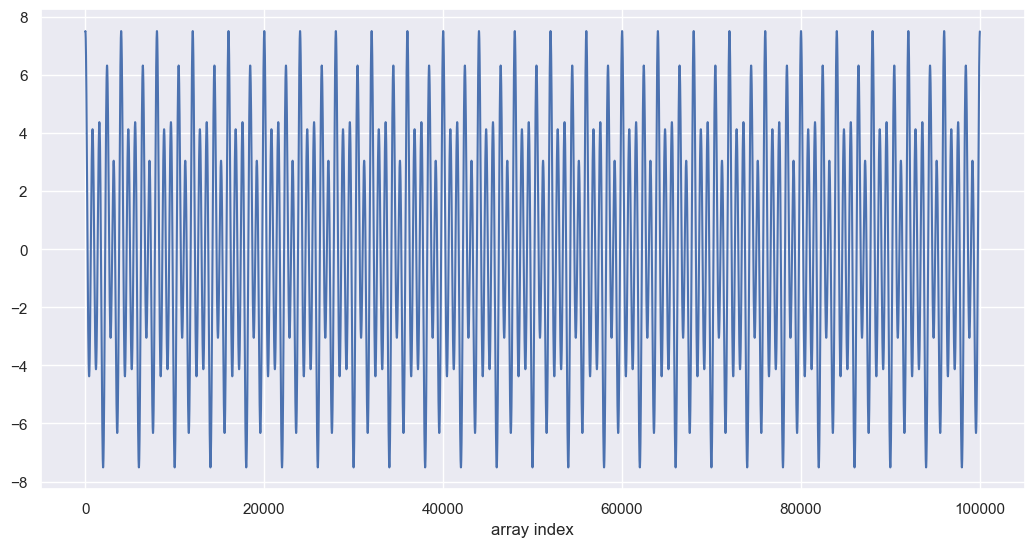

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(MAIN_DATA, '-')
ax.set_xlabel('array index')
plt.show()

# **As a good practice, always look at what you are feeding to the model**

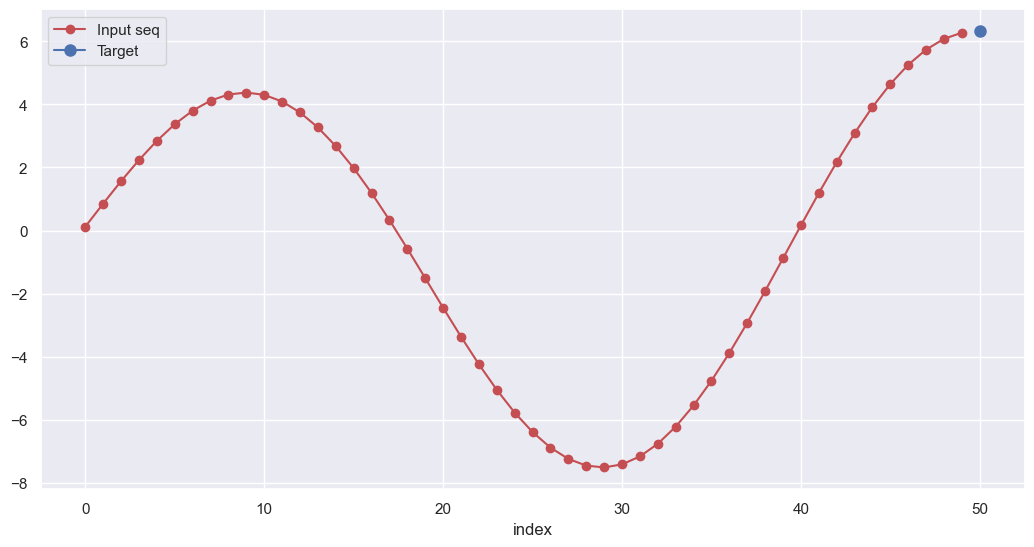

In [8]:
# pick a random index
ran_ind = np.random.randint(0, dataset.x.shape[1])

# NOTE: SeqData outputs in tensors.
# For plotting, we must detach and send to cpu
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), dataset.x[:,ran_ind].detach().cpu(), '-ro', label='Input seq', ms=6)
ax.plot(left_seq_size+np.arange(right_seq_size), dataset.y[:,ran_ind].detach().cpu(), '-bo', label='Target',ms=8)
ax.set_xlabel('index')
plt.legend()
plt.show()

# **Let's normalize and train-test split the data**

In [9]:
tot_dataset_len = dataset.x.shape[1]
train_size = int(0.9 * tot_dataset_len)
test_size = tot_dataset_len - train_size

norm_fac = torch.max(dataset.x)

Xtrain = dataset.x[:,0:train_size]/norm_fac
Ytrain = dataset.y[:,0:train_size]/norm_fac

Xtest = dataset.x[:,train_size:]/norm_fac
Ytest = dataset.y[:,train_size:]/norm_fac

Xval = val_dataset.x/norm_fac
Yval = val_dataset.y/norm_fac

print(f'Xtrain has {Xtrain.shape[1]} samples and each sample has {Xtrain.shape[0]} points.')
print(f'Ytrain has {Ytrain.shape[1]} samples and each sample has {Ytrain.shape[0]} points.')
print(f'Xtest has {Xtest.shape[1]} samples and each sample has {Xtest.shape[0]} points.')
print(f'Ytest has {Ytest.shape[1]} samples and each sample has {Ytest.shape[0]} points.\n\n')

print('******Validation dataset info********')
print(f'Xval has {Xval.shape[1]} samples and each sample has {Xval.shape[0]} points.')
print(f'Yval has {Yval.shape[1]} samples and each sample has {Yval.shape[0]} points.')

Xtrain has 1800 samples and each sample has 50 points.
Ytrain has 1800 samples and each sample has 1 points.
Xtest has 200 samples and each sample has 50 points.
Ytest has 200 samples and each sample has 1 points.


******Validation dataset info********
Xval has 200 samples and each sample has 50 points.
Yval has 200 samples and each sample has 100 points.


# **Look at the data once more to make sure things look good**

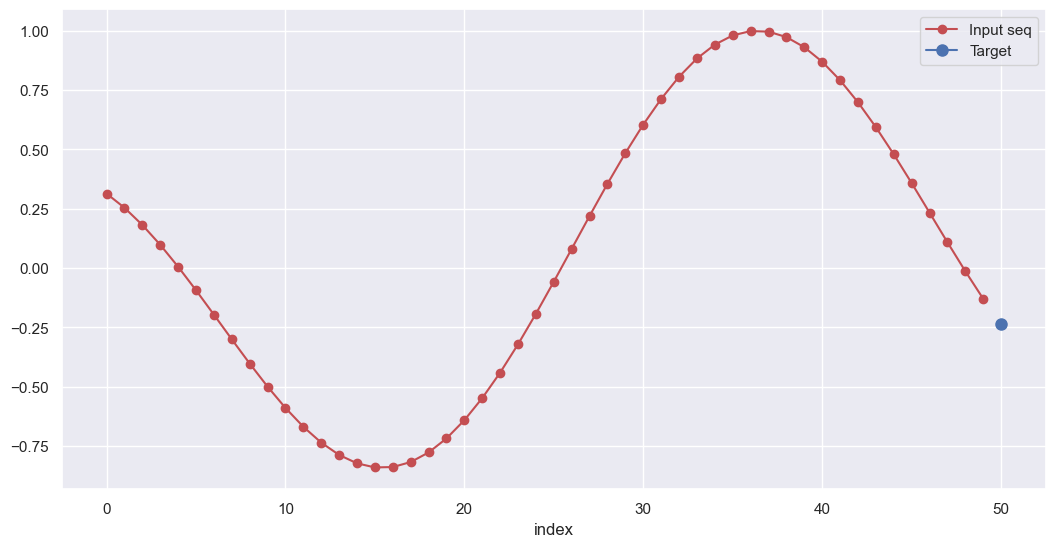

In [10]:
ran_ind = np.random.randint(0, Xtrain.shape[1])
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), Xtrain[:,ran_ind].cpu(), '-ro', label='Input seq', ms=6)
ax.plot(left_seq_size+np.arange(right_seq_size), Ytrain[:,ran_ind].cpu(), '-bo', label='Target',ms=8)
ax.set_xlabel('index')
plt.legend()
plt.show()

# **Time to define the model and run it!**

In [34]:
import os
cwd = os.getcwd()
print("cwd = ", cwd)

# make sure to give the full path
# the relevant function will 'cd' to this directory
save_path = "s:\\ACK\\PyTorch-RNN-Tutorial\\Saved_models"

print("save_path = ", save_path)

params = {
'train': True,
'EPOCHS': 20,
'num_layers': 1,
'hidden_size': 50,
'batch_size': 10,
'input_size': 1,
'learning_rate': 0.002,
'flavor': 'lstm',
'left_seq_size': left_seq_size,
'right_seq_size': right_seq_size,
'noise': noise,
'norm_fac': norm_fac,
'save_path': save_path,
'load_previous': True,
'encdec': False, # this notebooks only uses traditional RNN
'test': True,
'val': True, 
'save_model': True,
'iplot': True
}

data = {
    'Xtrain': Xtrain,
    'Ytrain': Ytrain,
    'Xtest': Xtest,
    'Ytest': Ytest,
    'Xval': Xval, 
    'Yval': Yval
}

#--------------------

CT = Create_and_Train(params, data, device)

cwd =  s:\ACK\PyTorch-RNN-Tutorial\Saved_models
save_path =  s:\ACK\PyTorch-RNN-Tutorial\Saved_models
**************************************************************************
RNN lstm Regression model initialized with 1 layers and 50 hidden size.
I will take in 50 points and predict 1 points
**************************************************************************
Found older file: L1_H50_lr0.002_input50_target1_noise0.0_epochs1to20.pth
Loading.....


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

# **Let's use the trained model to make prediction on one random instance of Xval**

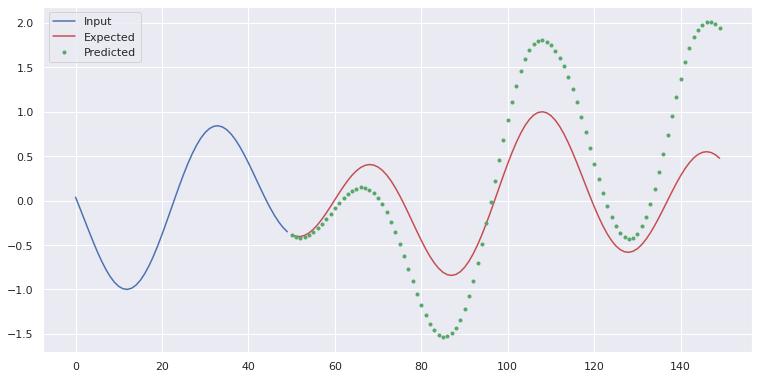

In [12]:
rand_inds=np.random.randint(0, Xval.shape[1], 1)

preds = CT.trainer.RNN_npoint_pred(Xval[:,rand_inds].to(device), val_right_seq_size) 

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), Xval[:,rand_inds], 'b-', label='Input')
ax.plot(left_seq_size+np.arange(Yval.shape[0]), Yval[:,rand_inds], 'r-', label='Expected')
ax.plot(left_seq_size+np.arange(Yval.shape[0]), preds.cpu(), 'g.', label='Predicted')
plt.legend()
plt.show()

# **Let's look at the mean square error file generated by the code**

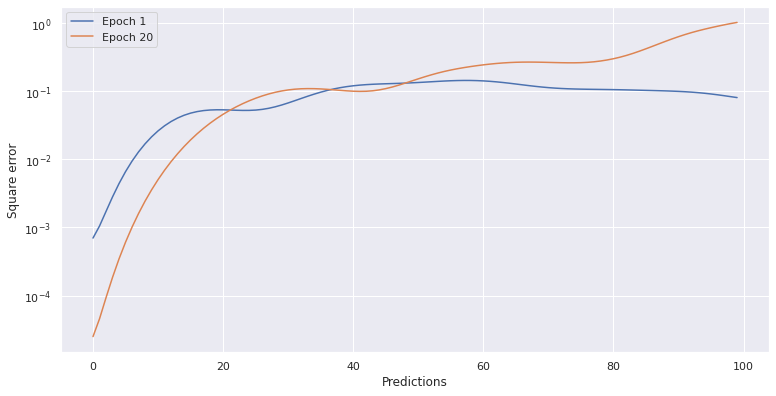

In [13]:
val_errors = np.load(CT.err_filename+'.npz')
val_err_mean = val_errors['mean']
val_err_std = val_errors['std']

# define error bounds using the standard deviation of
# the different predictions
upper =  val_err_mean + val_err_std
lower = val_err_mean - val_err_std

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
for i in [0,val_err_mean.shape[0]-1]: # visualize only first and last epoch
    ax.semilogy(np.arange(Yval.shape[0]), val_err_mean[i], label=f'Epoch {i+1}')
    # you can plot the standard dev bounds on the predictions but 
    # when using semigloy the -ve vals will create problems.
    #ax.fill_between(np.arange(Yval.shape[0]), upper[i], lower[i], alpha=0.2)
ax.set_xlabel('Predictions')
ax.set_ylabel('Square error')
plt.legend()
plt.show()